In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import numpy_groupies as npg

import scipy as sp
import scipy.signal

import itertools
import string
import pickle
import glob
import os
import re 

import tqdm.notebook as tqdm

import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

from collections import defaultdict

from utils.vis_3d import BrainSurface
from utils.stats import bootstrap_statistic, jackknife_correlation, manual_corr_along_axis, compute_null_correlation_jk
from utils.fooof_utils import get_foofed_spectrum_chanwise
from utils.plot import draw_four_views
from utils.colors import okabe, ripples_blue, ripples_orange, ripples_red, get_cmap_gamma_data
from utils.pyutils import get_subsystem, create_subsystem_map
from utils.burst import acf_mass_kurtosis, acf_magnitude
from utils.stats import compute_null_diff_freqwise, stratified_stats

from crosspy.core.autocorrelation import get_length_by_cdf, get_length_by_mean

%config InlineBackend.figure_format = 'jpg'

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=okabe)

In [4]:
lags_cycles = np.arange(200)/10

In [5]:
def load_all_meg_data(dir_path, lags_cycles, n_freqs=81, reduce=True):
    meg_files = glob.glob(dir_path + '\\*_parcels.pickle')

    cohort_pacf = list()
    cohort_codes = list()
    cohort_psd = list()

    for subj_idx, fname in enumerate(tqdm.tqdm(meg_files)):
        subj_code = os.path.split(fname)[~0].split('_')[0]
        
        subj_psd_fname = os.path.join(dir_path, subj_code + '_psd.pickle')
        
        subj_fdata = pickle.load(open(fname, 'rb'))
        f_vals = np.array(subj_fdata['frequencies'])
        subj_ns = [600*1000 for n in range(subj_fdata['pac'].shape[0])]

        subj_pacf_lengths = np.apply_along_axis(get_length_by_cdf, -1, subj_fdata['pac'], lags_cycles, 0.9, interpolate=False)

        if os.path.exists(subj_psd_fname):
            subj_psd_data = pickle.load(open(subj_psd_fname, 'rb'))
            subj_psd_arr = subj_psd_data['psd']
            
            psd_frequencies = subj_psd_data['frequencies']
            
            try:
                subj_psd_arr = np.array([get_foofed_spectrum_chanwise(psd_frequencies, arr.T, freqs_to_map=f_vals, normalize=False) for arr in subj_psd_arr])
            except Exception as e:
                print(e)
                subj_psd_arr = np.zeros((subj_fdata['pac'].shape[0], len(f_vals),400))
        else:
            subj_psd_arr = np.zeros((subj_fdata['pac'].shape[0], len(f_vals),400))
        
        if reduce:
            cohort_pacf.append(np.nanmean(subj_pacf_lengths, axis=0))
            cohort_codes.append(subj_code)
            cohort_psd.append(subj_psd_arr.mean(axis=0))
        else:
            cohort_pacf.extend(subj_pacf_lengths)
            cohort_codes.extend([subj_code]*len(subj_pacf_lengths))
            cohort_psd.extend(subj_psd_arr)

    return np.array(cohort_codes), np.array(cohort_pacf), np.array(cohort_psd)

In [6]:
def get_channel_names(path):
    fname = glob.glob(path + '\\*_parcels.pickle')[0]
    return [n.strip() for n in pickle.load(open(fname, 'rb'))['channel_names']]

In [7]:
yeo7_parc_fname = r'L:\nttk_palva\Utilities\parcellations\parc_info_old\parc2018yeo7_400_info.csv'
yeo17_parc_fname = r'L:\nttk_palva\Utilities\parcellations\parc_info_old\parc2018yeo17_400_info.csv'
yeo7_to_17_mapping_fname  = r'L:\nttk_palva\Utilities\parcellations\parc_info_old\mapping_7_17_old\7_to_17_400.csv'
yeo7_to_17_mapping_df  = pd.read_csv(yeo7_to_17_mapping_fname, header=None, sep=';')
yeo7_to_17_mapping_indices = yeo7_to_17_mapping_df.sort_values(by=3)[1].values

In [8]:
anxiety_path = r'L:\nttk-data3\palva\Vlad\pac_meg_anxiety_resting_states'
depression_path = r'L:\nttk-data3\palva\Vlad\pac_meg_depression_resting_states'
controls_path = r'L:\nttk-data3\palva\Vlad\pac_meg_controls_rs_omega_7.5_signal_freq'

In [9]:
yeo7_parcels_orig = get_channel_names(anxiety_path)
mdd_parcels_orig = get_channel_names(depression_path)
control_parcels_orig = get_channel_names(controls_path)

In [10]:
# subsystem_to_index = {s:idx for (idx, s) in enumerate(set(cortical_subsystems))}
cortical_subsystems = np.array([get_subsystem(n) for n in control_parcels_orig])
subsystem_to_index = create_subsystem_map(cortical_subsystems)
index_to_subsystem = {v:k for (k,v) in subsystem_to_index.items()}
subsystem_indices = np.array([subsystem_to_index[s] for s in cortical_subsystems])

In [11]:
control_codes_reduced, control_pacf_reduced, control_psd_reduced = load_all_meg_data(controls_path, lags_cycles, reduce=True)

anxiety_codes_reduced_orig, anxiety_pacf_reduced_orig,  anxiety_psd_reduced_orig = load_all_meg_data(anxiety_path, lags_cycles, reduce=True)
mdd_codes_reduced, mdd_pacf_reduced_orig, mdd_psd_reduced_orig = load_all_meg_data(depression_path, lags_cycles, reduce=True)

  0%|          | 0/54 [00:00<?, ?it/s]

d:\Vlad\Anaconda3\envs\seeg_meso_env\lib\site-packages\crosspy-0.0.1b0-py3.7.egg\crosspy\core\autocorrelation.py:27: RuntimeWarning: invalid value encountered in true_divide


  0%|          | 0/18 [00:00<?, ?it/s]

The input power spectra data, after logging, contains NaNs or Infs. This will cause the fitting to fail. One reason this can happen is if inputs are already logged. Inputs data should be in linear spacing, not log.


  0%|          | 0/42 [00:00<?, ?it/s]

In [12]:
anxiety_pacf_reduced = np.take(anxiety_pacf_reduced_orig, yeo7_to_17_mapping_indices, axis=-1)
mdd_pacf_reduced = np.take(mdd_pacf_reduced_orig, yeo7_to_17_mapping_indices, axis=-1)

In [13]:
mdd_psd_reduced = np.take(mdd_psd_reduced_orig, yeo7_to_17_mapping_indices, axis=-1)
anxiety_psd_reduced = np.take(anxiety_psd_reduced_orig, yeo7_to_17_mapping_indices, axis=-1)

In [14]:
cognitive_scores = pd.read_excel(r'meso_data\scores_demogr_clinical.xlsx', na_values=-1.0)
cognitive_scores = cognitive_scores.append({'subj':'S0152'}, ignore_index=True)
cognitive_scores.drop_duplicates(subset='subj', inplace=True)
cognitive_scores.replace(-1.0, np.nan, inplace=True)

In [15]:
weird_subjects = ['D0382', 'D0345', 'S0171']

In [16]:
all_codes = anxiety_codes_reduced_orig.tolist() + mdd_codes_reduced.tolist() + control_codes_reduced.tolist()
all_pacf_reduced = np.concatenate([anxiety_pacf_reduced, mdd_pacf_reduced, control_pacf_reduced])
all_psd_reduced = np.concatenate([anxiety_psd_reduced, mdd_psd_reduced, control_psd_reduced])

all_cognitive_scores = cognitive_scores.set_index('subj').loc[all_codes].dropna(how='all', axis=1)
all_cognitive_scores['cohort'] = [s[0] for s in all_cognitive_scores.index]
all_cognitive_scores['medication'].fillna(0.0, inplace=True)

all_cognitive_scores.reset_index(inplace=True)
all_cognitive_scores.reset_index(inplace=True)

all_cognitive_scores.dropna(how='all', axis=1, inplace=True)
all_cognitive_scores['good'] = ~all_cognitive_scores['subj'].isin(weird_subjects)

In [17]:
f_vals = [2]

while f_vals[~0] < 99:
    f_vals.append(f_vals[~0]*1.05)

f_vals = np.array(f_vals)

In [18]:
mdd_controls_mask = (all_cognitive_scores['cohort'] != 'A') & (all_cognitive_scores['good'])
mdd_controls_scores = all_cognitive_scores[mdd_controls_mask]

In [19]:
dep_metric = 'BDI-II'
mdd_mask = np.isfinite(mdd_controls_scores[dep_metric])  & (mdd_controls_scores['good']) & (mdd_controls_scores['cohort'] == 'D')
controls_mask = np.isfinite(mdd_controls_scores[dep_metric])  & (mdd_controls_scores['good']) & (mdd_controls_scores['cohort'] == 'S')

In [20]:
mdd_pacf_reduced = all_pacf_reduced[mdd_controls_scores[mdd_mask]['index'].values]
mdd_bdi_scores = mdd_controls_scores[mdd_mask][dep_metric].values

In [21]:
jk_bdi_corr_sp, jk_bdi_corr_pv_sp = jackknife_correlation(mdd_pacf_reduced, mdd_bdi_scores, corr_callable=manual_corr_along_axis, corr_func=sp.stats.spearmanr)

In [22]:
all_psd_reduced = np.concatenate([anxiety_psd_reduced, mdd_psd_reduced, control_psd_reduced])
mdd_psd_reduced = all_psd_reduced[mdd_controls_scores[mdd_mask]['index'].values]

jk_bdi_corr_sp_psd, jk_bdi_corr_pv_sp_psd = jackknife_correlation(mdd_psd_reduced, mdd_bdi_scores, corr_callable=manual_corr_along_axis, corr_func=sp.stats.pearsonr)

In [23]:
corr_null_distr = compute_null_correlation_jk(mdd_psd_reduced, mdd_bdi_scores, corr_func='spearmanr', n_rounds=1000)
corr_null_level = np.percentile(corr_null_distr.max(axis=-1), 95, axis=0).mean()

In [24]:
burst_bdi_corr_sp, burst_bdi_corr_pv_sp = manual_corr_along_axis(mdd_pacf_reduced, mdd_bdi_scores, corr_func=sp.stats.spearmanr)
burst_bdi_corr, burst_bdi_corr_pv = manual_corr_along_axis(mdd_pacf_reduced, mdd_bdi_scores)

In [25]:
diff_null = compute_null_diff_freqwise(all_pacf_reduced[mdd_controls_mask], 40, n_rounds=1000)

all_pacf_stratified = stratified_stats(all_pacf_reduced, mdd_controls_scores, n_rounds=1000)

all_pacf_stratified_5  = np.percentile(all_pacf_stratified[0].mean(axis=-1), q=(5,95), axis=0)
all_pacf_stratified_95 =  np.percentile(all_pacf_stratified[1].mean(axis=-1), q=(5,95), axis=0)

cohorts_diff = np.diff(all_pacf_stratified, axis=0)[0]
diff_baseline = np.percentile(diff_null, 95,  axis=(0,-1), keepdims=True)

In [26]:
all_psd_stratified = stratified_stats(all_psd_reduced, mdd_controls_scores, n_rounds=1000)

all_psd_stratified_5  = np.percentile(all_psd_stratified[0], q=(5,95), axis=0)
all_psd_stratified_95 =  np.percentile(all_psd_stratified[1], q=(5,95), axis=0)

In [27]:
psd_diff_null = compute_null_diff_freqwise(all_psd_reduced[mdd_controls_mask], 40, n_rounds=1000)

In [28]:
psd_diff_parcelwise = all_psd_stratified[0].mean(axis=(0)) - all_psd_stratified[1].mean(axis=(0))

psd_diff_baseline = np.percentile(psd_diff_null.max(axis=0, keepdims=True), 99, axis=-1)
psd_diff_sign_parcelwise_pos =  (psd_diff_parcelwise > psd_diff_baseline)
psd_diff_sign_parcelwise_neg =  (psd_diff_parcelwise < -psd_diff_baseline)

psd_diff_bootwise = (all_psd_stratified[0] - all_psd_stratified[1])

psd_diff_sign_pos_5 = (psd_diff_bootwise > psd_diff_baseline).mean(axis=-1).mean(axis=0) - (psd_diff_bootwise > psd_diff_baseline).mean(axis=-1).std(axis=0)
psd_diff_sign_pos_95 = (psd_diff_bootwise > psd_diff_baseline).mean(axis=-1).mean(axis=0) + (psd_diff_bootwise > psd_diff_baseline).mean(axis=-1).std(axis=0)

psd_diff_sign_neg_5 = (psd_diff_bootwise < -psd_diff_baseline).mean(axis=-1).mean(axis=0) - (psd_diff_bootwise < -psd_diff_baseline).mean(axis=-1).std(axis=0)
psd_diff_sign_neg_95 = (psd_diff_bootwise < -psd_diff_baseline).mean(axis=-1).mean(axis=0) + (psd_diff_bootwise < -psd_diff_baseline).mean(axis=-1).std(axis=0)


In [29]:
diff_parcelwise = all_pacf_stratified[0].mean(axis=(0)) - all_pacf_stratified[1].mean(axis=(0))

diff_baseline = np.percentile(diff_null.max(axis=0, keepdims=True), 95, axis=-1)
diff_sign_parcelwise_pos =  (diff_parcelwise > diff_baseline)
diff_sign_parcelwise_neg =  (diff_parcelwise < -diff_baseline)

diff_sign_bootwise_pos = ((all_pacf_stratified[0] - all_pacf_stratified[1]) > diff_baseline)
diff_bootwise = (all_pacf_stratified[0] - all_pacf_stratified[1])

diff_sign_pos_5 = (diff_bootwise > diff_baseline).mean(axis=-1).mean(axis=0) - (diff_bootwise > diff_baseline).mean(axis=-1).std(axis=0)
diff_sign_pos_95 = (diff_bootwise > diff_baseline).mean(axis=-1).mean(axis=0) + (diff_bootwise > diff_baseline).mean(axis=-1).std(axis=0)

diff_sign_neg_5 = (diff_bootwise < -diff_baseline).mean(axis=-1).mean(axis=0) - (diff_bootwise < -diff_baseline).mean(axis=-1).std(axis=0)
diff_sign_neg_95 = (diff_bootwise < -diff_baseline).mean(axis=-1).mean(axis=0) + (diff_bootwise < -diff_baseline).mean(axis=-1).std(axis=0)

In [30]:
fsaverage_path = r'L:\nttk-data2\palva\Common repos\_fsaverage\fsaverage'

brain_surf_lh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['lh'], surface='inflated')
brain_surf_rh = BrainSurface(fsaverage_path, parcellation='Schaefer2018_400Parcels_17Networks_order', 
                             hemis=['rh'], surface='inflated')

surf_parcel_names = brain_surf_lh.parcel_names[1:] + brain_surf_rh.parcel_names[1:]
brain_3d_surfaces = [brain_surf_lh, brain_surf_rh]

In [31]:
new_rdbu_data = np.vstack(
                     (get_cmap_gamma_data('Blues', 3.5)[::-1],
                       get_cmap_gamma_data('Reds', 3.5))
                       )

new_rdbu_cmp = mpl.colors.LinearSegmentedColormap.from_list('myrdbu', new_rdbu_data, 256, gamma=1)
new_reds_cmp = mpl.colors.LinearSegmentedColormap.from_list('myreds', plt.get_cmap('Reds')(np.linspace(0,1,128)), 256, gamma=3.5)
new_blues_cmp = mpl.colors.LinearSegmentedColormap.from_list('myblues', plt.get_cmap('Blues')(np.linspace(0,1,128)), 256, gamma=3.5)


In [32]:
corr_mean_ss = npg.aggregate(subsystem_indices, (jk_bdi_corr_sp >= corr_null_level)[:, 33:36].mean(axis=(0,1)), func=np.mean)
corr_std_ss = npg.aggregate(subsystem_indices, (jk_bdi_corr_sp >= corr_null_level)[:, 33:36].mean(axis=(1)), func=np.mean, axis=-1).std(axis=0)

In [33]:
pacf_diff_ss = npg.aggregate(subsystem_indices, diff_sign_parcelwise_pos[30:33].mean(axis=0), func=np.mean)
pacf_diff_std_ss = npg.aggregate(subsystem_indices, diff_sign_bootwise_pos[:, 28:32].mean(axis=1), func=np.mean, axis=-1).std(axis=0)

In [34]:
corr_mean_sign = (jk_bdi_corr_sp >= corr_null_level).mean(axis=(0,-1))
corr_std_sign = (jk_bdi_corr_sp >= corr_null_level).mean(axis=(-1)).std(axis=0)

In [35]:
7/10*15

10.5

In [36]:
control_parcels_fixed = [n[:-3] for n in control_parcels_orig]

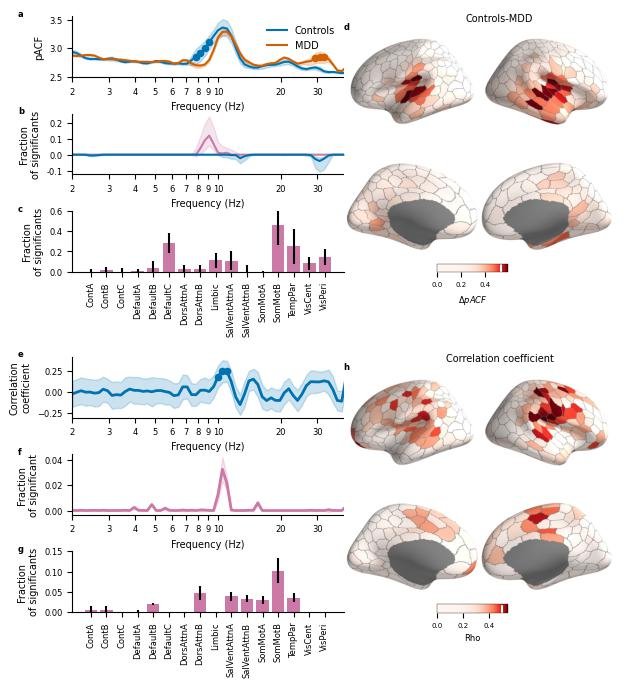

In [40]:
fig = plt.figure(figsize=(7,10.5))

main_spec = fig.add_gridspec(nrows=3, ncols=1, hspace=0.4, height_ratios=[2,2,1])

top_spec = main_spec[0].subgridspec(ncols=2, nrows=1, wspace=0.0)
mid_spec = main_spec[1].subgridspec(ncols=2, nrows=1, wspace=0.0)
bot_spec = main_spec[2].subgridspec(ncols=4, nrows=1, wspace=0.3)

pacf_spectrum_spec = top_spec[0].subgridspec(ncols=1, nrows=3, hspace=0.6)
pacf_brain_spec = top_spec[1].subgridspec(ncols=2, nrows=2, hspace=0, wspace=0)

pacf_spectrum_axes = [fig.add_subplot(pacf_spectrum_spec[i]) for  i in range(3)]
pacf_brain_axes = np.array([fig.add_subplot(pacf_brain_spec[i,j]) for (i,j) in itertools.product([0,1],[0,1])]).reshape(2,2)

corr_spectrum_spec = mid_spec[0].subgridspec(ncols=1, nrows=3, hspace=0.6)
corr_brain_spec = mid_spec[1].subgridspec(ncols=2, nrows=2, hspace=0, wspace=0)

corr_spectrum_axes = [fig.add_subplot(corr_spectrum_spec[i]) for  i in range(3)]
corr_brain_axes = np.array([fig.add_subplot(corr_brain_spec[i,j]) for (i,j) in itertools.product([0,1],[0,1])]).reshape(2,2)
    
pacf_spectrum_axes[0].semilogx(f_vals, all_pacf_stratified.mean(axis=(1,-1))[0], color=ripples_blue, label='Controls')
pacf_spectrum_axes[0].fill_between(f_vals, all_pacf_stratified_5[0], all_pacf_stratified_5[1], color=ripples_blue, alpha=0.2)

pacf_spectrum_axes[0].semilogx(f_vals, all_pacf_stratified.mean(axis=(1,-1))[1], color=ripples_orange, label='MDD')
pacf_spectrum_axes[0].fill_between(f_vals, all_pacf_stratified_95[0], all_pacf_stratified_95[1], color=ripples_orange, alpha=0.2)

pacf_spectrum_axes[0].scatter(f_vals[28:32], all_pacf_stratified.mean(axis=(1,-1))[0][28:32], color=ripples_blue, s=20)

pacf_spectrum_axes[1].semilogx(f_vals, diff_sign_parcelwise_pos.mean(axis=-1), ms=5, label='Positive', color=ripples_red)
pacf_spectrum_axes[1].fill_between(f_vals, diff_sign_pos_5, diff_sign_pos_95, color=ripples_red, alpha=0.2)

pacf_spectrum_axes[1].semilogx(f_vals, -diff_sign_parcelwise_neg.mean(axis=-1), ms=5, color=ripples_blue, label='Negative')
pacf_spectrum_axes[1].fill_between(f_vals, -diff_sign_neg_5, -diff_sign_neg_95, color=ripples_blue, alpha=0.2)

pacf_spectrum_axes[0].scatter(f_vals[55:58], all_pacf_stratified.mean(axis=(1,-1))[1][55:58], s=20, color=ripples_orange)

pacf_spectrum_axes[0].legend(frameon=False, fontsize=7)

pacf_spectrum_axes[2].bar(np.arange(16), pacf_diff_ss, yerr=pacf_diff_std_ss , color=ripples_red)
pacf_spectrum_axes[2].set_ylim([0, 0.6])

for band_idx, views_axes, title in zip([slice(28,32)], [pacf_brain_axes], ['Low alpha']):
    vals_agg = diff_parcelwise[band_idx].mean(axis=0)
    vmax = np.percentile(np.abs(vals_agg), 99)
    vmin = 0

    draw_four_views(views_axes, vals_agg, control_parcels_fixed, brain_3d_surfaces, cbar_loc='bottom', title_kwargs={'fontsize': 7},
                cmap=new_reds_cmp, title=f'Controls-MDD', norm_values=(vmin, vmax))  
    
corr_spectrum_axes[0].semilogx(f_vals, jk_bdi_corr_sp.mean(axis=(0,-1)), label='Correlation spearman', color=ripples_blue, lw=2)
corr_spectrum_axes[0].fill_between(f_vals, jk_bdi_corr_sp.mean(axis=(0,-1)) - jk_bdi_corr_sp.std(axis=(0,-1)),
                                           jk_bdi_corr_sp.mean(axis=(0,-1)) + jk_bdi_corr_sp.std(axis=(0,-1)), 
                                           color=ripples_blue, alpha=0.2)

corr_spectrum_axes[0].scatter(f_vals[33:36], jk_bdi_corr_sp.mean(axis=(0,-1))[33:36], color=ripples_blue, s=20)
corr_spectrum_axes[1].semilogx(f_vals, corr_mean_sign, label='Correlation spearman', color=ripples_red, lw=2)
corr_spectrum_axes[1].fill_between(f_vals, corr_mean_sign - corr_std_sign, corr_mean_sign + corr_std_sign, color=ripples_red, alpha=0.2)

pacf_spectrum_axes[1].set_yticks([-0.1, 0.0, 0.1, 0.2])
pacf_spectrum_axes[1].set_yticklabels([-0.1, 0.0, 0.1, 0.2])

corr_spectrum_axes[2].bar(np.arange(16), corr_mean_ss, yerr=corr_std_ss, color=ripples_red)
corr_spectrum_axes[2].set_ylim([0,0.15])

for band_idx, title in zip([slice(34,35)], ['Alpha']):
    vals_agg = jk_bdi_corr_sp.mean(axis=0)[band_idx].mean(axis=0)
    vmax = np.percentile(np.abs(vals_agg), 99)
    vmin = -vmax

    draw_four_views(corr_brain_axes, vals_agg, control_parcels_fixed, brain_3d_surfaces, cbar_loc='bottom', title_kwargs={'fontsize': 7},
                cmap=new_reds_cmp, title=f'Correlation coefficient', norm_values=(0, vmax))  
    
for ax, ylabel in zip(pacf_spectrum_axes[:2] + corr_spectrum_axes[:2], ['pACF', 'Fraction\nof significants', 'Correlation\ncoefficient', 'Fraction\nof significant',]):
    ax.set_xlim([2,40])
    ax.set_xlabel('Frequency (Hz)', fontsize=7)
    ax.set_ylabel(ylabel, fontsize=7)
    ax.set_xticks([2,3,4,5,6,7,8,9,10,20,30], fontsize=5)
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    ax.tick_params(labelsize=6)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
for ax, ylabel in zip([pacf_spectrum_axes[2], corr_spectrum_axes[2]], ['Fraction\nof significants','Fraction\nof significants',]):
    ax.set_ylabel(ylabel, fontsize=7)
    
    ax.set_xticks(np.arange(16))
    ax.set_xticklabels([index_to_subsystem[i] for i in range(16)], rotation=90, fontsize=6)
    ax.tick_params(labelsize=6)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    
for ax, label in zip(fig.axes[-2:], ['$\Delta pACF$', 'Rho']):
    ax.set_xlabel(label, fontsize=6)
    ax.tick_params(labelsize=5)
    
fig.axes[~0].plot([corr_null_level, corr_null_level], [0,1], color='white', ls='--')
fig.axes[~0].set_ylim([0,1])
    
fig.axes[~1].plot([diff_baseline, diff_baseline], [0,1], color='white', ls='--')
fig.axes[~1].set_ylim([0,1])
    

labeled_axes = pacf_spectrum_axes + [pacf_brain_axes[0,0]] + corr_spectrum_axes + [corr_brain_axes[0,0]] #+ [scatter_axes[0]] 

for ax, label in zip(labeled_axes, string.ascii_lowercase):
    # offset = 0.05 if (ax in [pacf_brain_axes[0,0], corr_brain_axes[0,0]]) else -0.15
    if (ax in [pacf_brain_axes[0,0], corr_brain_axes[0,0]]):
        offset = 0.00
    else:
        offset = -0.2
        
    ax.text(offset, 1, label, transform=ax.transAxes, weight='bold', size=6)
    
fig.savefig('publication_figures/figure_7_mdd.png', dpi=300, bbox_inches='tight')


for format in ['svg', 'pdf']:
    fig.savefig(f'publication_figures_vector/figure_7.{format}', dpi=300, bbox_inches="tight")

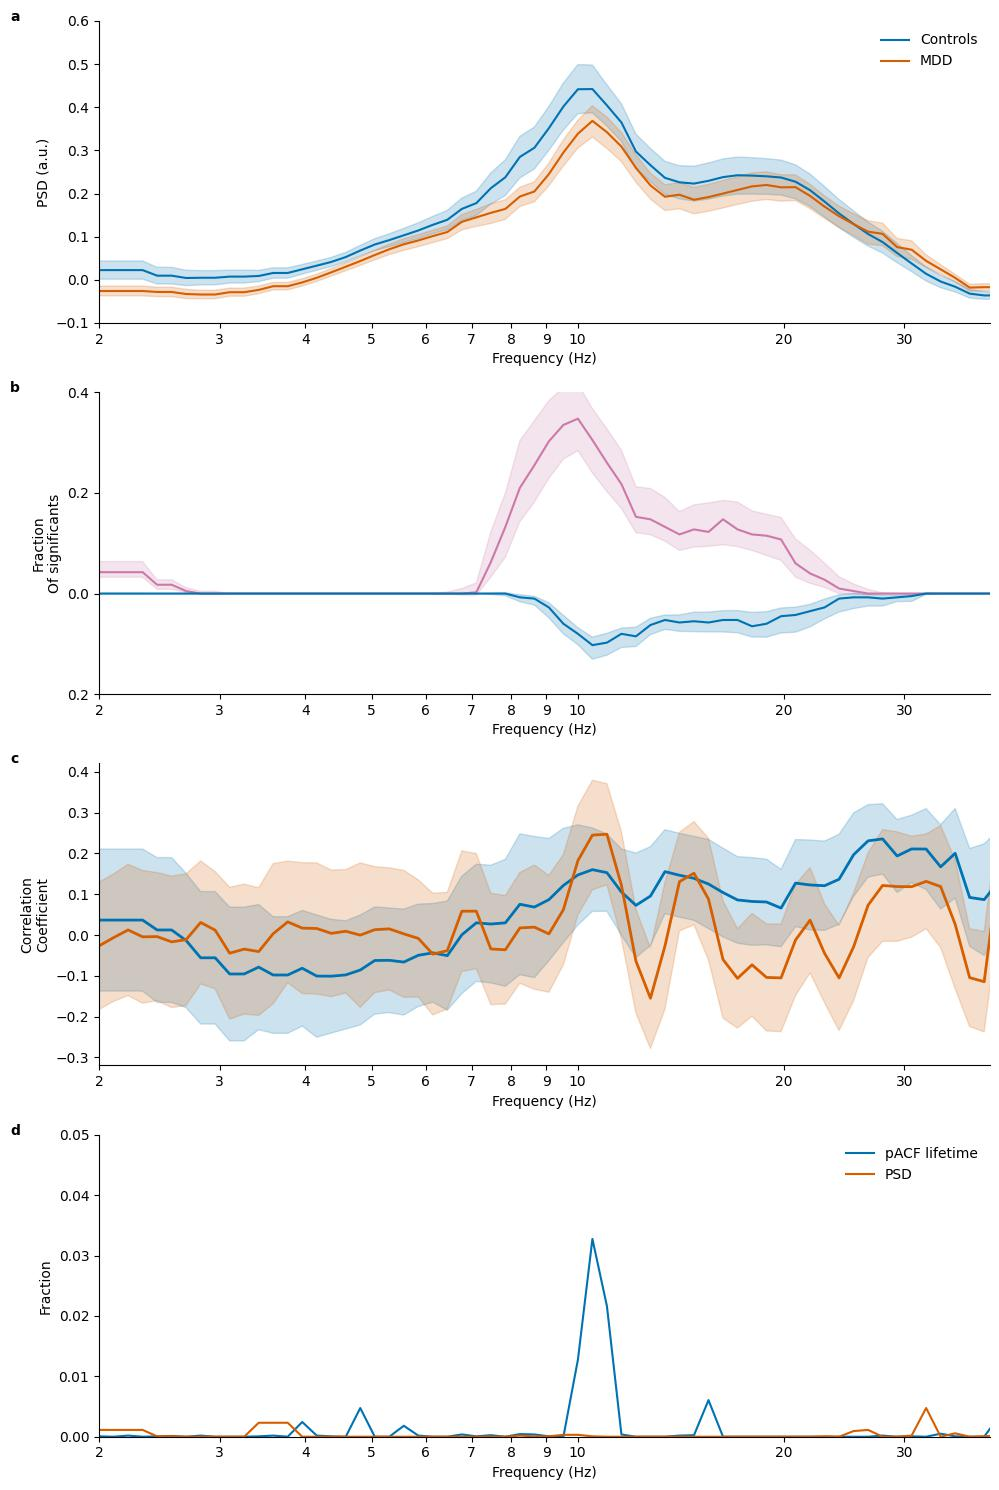

In [38]:
fig, axes = plt.subplots(figsize=(10,15), nrows=4)

axes[0].semilogx(f_vals, all_psd_stratified.mean(axis=(1,-1))[0], color=ripples_blue, label='Controls')
axes[0].fill_between(f_vals, all_psd_stratified_5[0].mean(axis=-1), all_psd_stratified_5[1].mean(axis=-1), color=ripples_blue, alpha=0.2)

axes[0].semilogx(f_vals, all_psd_stratified.mean(axis=(1,-1))[1], color=ripples_orange, label='MDD')
axes[0].fill_between(f_vals, all_psd_stratified_95[0].mean(axis=-1), all_psd_stratified_95[1].mean(axis=-1), color=ripples_orange, alpha=0.2)

axes[1].semilogx(f_vals, psd_diff_sign_parcelwise_pos.mean(axis=-1), ms=5, label='Positive', color=ripples_red)
axes[1].fill_between(f_vals, psd_diff_sign_pos_5, psd_diff_sign_pos_95, color=ripples_red, alpha=0.2)

axes[1].semilogx(f_vals, -psd_diff_sign_parcelwise_neg.mean(axis=-1), ms=5, color=ripples_blue, label='Negative')
axes[1].fill_between(f_vals, -psd_diff_sign_neg_5, -psd_diff_sign_neg_95, color=ripples_blue, alpha=0.2)

# pacf_spectrum_axes[0].scatter(f_vals[55:58], all_pacf_stratified.mean(axis=(1,-1))[1][55:58], s=50, color=orange_color)
axes[0].legend(frameon=False)

axes[2].semilogx(f_vals, jk_bdi_corr_sp_psd.mean(axis=(0,-1)), label='PSD', color=ripples_blue, lw=2)
axes[2].fill_between(f_vals, jk_bdi_corr_sp_psd.mean(axis=(0,-1)) - jk_bdi_corr_sp_psd.std(axis=(0,-1)),
                                           jk_bdi_corr_sp_psd.mean(axis=(0,-1)) + jk_bdi_corr_sp_psd.std(axis=(0,-1)), 
                                           color=ripples_blue, alpha=0.2)

axes[2].semilogx(f_vals, jk_bdi_corr_sp.mean(axis=(0,-1)), label='pACF', color=ripples_orange, lw=2)
# axes[2].semilogx(f_vals, jk_bdi_corr_sp.mean(axis=(0)), label='pACF', color=orange_color, lw=2)
axes[2].fill_between(f_vals, jk_bdi_corr_sp.mean(axis=(0,-1)) - jk_bdi_corr_sp.std(axis=(0,-1)),
                                           jk_bdi_corr_sp.mean(axis=(0,-1)) + jk_bdi_corr_sp.std(axis=(0,-1)), 
                                           color=ripples_orange, alpha=0.2)


# axes[2].hlines([corr_null_level, -corr_null_level], 2, 40, ls='--', color='black')

axes[3].semilogx(f_vals, (jk_bdi_corr_sp >= corr_null_level).mean(axis=(0,-1)), label='pACF lifetime')
axes[3].semilogx(f_vals, (jk_bdi_corr_sp_psd >= corr_null_level).mean(axis=(0,-1)), label='PSD')


axes[0].set_ylim([-0.1, 0.6])
axes[1].set_ylim([-0.2, 0.4])
for ax, ylabel in zip(axes, ['PSD (a.u.)', 'Fraction\nOf significants', 'Correlation\nCoefficient', 'Fraction']):
    ax.set_xlim([2,40])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(ylabel)
    ax.set_xticks([2,3,4,5,6,7,8,9,10,20,30])
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.minorticks_off()
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    
axes[1].set_yticks([-0.2, 0.0, 0.2, 0.4])
axes[1].set_yticklabels([0.2, 0.0, 0.2, 0.4])

axes[3].set_ylim([0.0, 0.05])
axes[3].legend(frameon=False)

for ax, label in zip(axes,  string.ascii_lowercase):
    offset = -0.1
        
    ax.text(offset, 1, label, transform=ax.transAxes, weight='bold')

fig.tight_layout()

    
fig.savefig('publication_figures/figure_7_mdd_supp.png', dpi=300)